# Demonstrate ADES Execution for OGC Application Packages
## This notebook runs through some example API calls to the ADES (Application, Deployment Execution Service) component of the EODH Platform

In [165]:
!pip install urllib3
!pip install pillow
!pip install matplotlib

In [166]:
import json
import time
import urllib3
http = urllib3.PoolManager(cert_reqs='CERT_NONE')
urllib3.disable_warnings() ## to avoid SSL warnings

In [167]:
## Define text colour for later output
class bcolors:
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    ENDC = '\033[0m'

In [168]:
from dotenv import load_dotenv
import os

# Load environment variables from the .env file (if present)
# load_dotenv("./tj-env")


In [178]:
## Place your workspace-scoped API token here
workspace = "tjellicoe-tpzuk" # must align with the workspace-scoped token used above
auth_dict = {"Authorization": f"Bearer {api_token}"}
auth_dict_prod = {"Authorization": f"Bearer {api_token_prod}"}

## Below are some example API requests you can make to the ADES component
Feel free to run these examples and change the inputs by specifying the application packages, process name and process inputs.

As an example we provide three EOEPCA-developed OGC Application Package to demonstrate the successful execution using the ADES deployment:
- [convert-url](https://github.com/EOEPCA/convert/blob/main/convert-url-app.cwl) - take an image specified by a URL and resize it by a given scale percentage
- [convert-stac](https://github.com/EOEPCA/convert/blob/main/convert-stac-app.cwl) - take an image specified by a stac item and resize it by a given scale percentage
- [water-bodies](https://github.com/EOEPCA/deployment-guide/blob/main/deploy/samples/requests/processing/water-bodies-app.cwl) - takes STAC items, area of interest, epsg definition and set of bands and identifies water bodies based on NDWI and Otsu threshold

This application is specified by configuring the below variable

In [141]:
process_to_be_run = "snuggs"

In [169]:
# Update these variables as required to identify the running ades instance and specify workspace name
# If the workspace does not yet exect, it will be created by the ades automatically
wr_endpoint = "staging.eodatahub.org.uk/api/catalogue/stac/catalogs/user/catalogs"

# Automated configuration of CWL script location, process name and inputs
if process_to_be_run == "convert-url":
    process_name = "convert-url"
    cwl_location = "https://raw.githubusercontent.com/EO-DataHub/eodhp-ades-demonstration/refs/heads/main/convert-url-app.cwl"
    inputs_dict = {"inputs": {
                    "fn": "resize",
                    "url":  "https://eoepca.org/media_portal/images/logo6_med.original.png",
                    "size": "50%"
                    }
                  }
elif process_to_be_run == "convert-stac":
    process_name = "convert-stac"
    cwl_location = "https://raw.githubusercontent.com/EO-DataHub/eodhp-ades-demonstration/refs/heads/main/convert-stac-app.cwl"
    inputs_dict = {"inputs": {
                    "fn": "resize",
                    "stac":  "https://raw.githubusercontent.com/EOEPCA/convert/main/stac/eoepca-logo.json",
                    "size": "50%"
                    }
                  }

elif process_to_be_run == "water-bodies":
    process_name = "water-bodies"
    cwl_location = "https://raw.githubusercontent.com/EO-DataHub/eodhp-ades-demonstration/refs/heads/main/water-bodies-app.cwl"
    inputs_dict = {"inputs": {
                    "stac_items": [
                        "https://earth-search.aws.element84.com/v1/collections/sentinel-2-c1-l2a/items/S2B_T42MVU_20240319T054135_L2A"
                    ],
                    "aoi": "68.09, -6.42, 69.09, -5.43",
                    "epsg": "EPSG:4326",
                    "bands": [
                        "green",
                        "nir"
                    ]
                    }
                  }
elif process_to_be_run == "snuggs":
    process_name = "snuggs"
    cwl_location = "https://raw.githubusercontent.com/EO-DataHub/eodhp-ades-demonstration/refs/heads/main/snuggs.cwl"
    inputs_dict = {"inputs": {
                    "input_reference": [
                        "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A"
                    ],
                    "s_expression": "ndvi: (/ (- B08 B04) (+ B08 B04))" 
                    }
                  }

### List processes

In [170]:
url = f"https://{wr_endpoint}/{workspace}/processes"
headers = {"Accept": "application/json"}
headers.update(auth_dict)
response = http.request('GET', url, headers=headers)
json.loads(response.data)

{'processes': [{'id': 'echo',
   'title': 'Echo input',
   'description': 'Simply echo the value provided as input',
   'mutable': False,
   'version': '2.0.0',
   'metadata': [{'title': 'Demo'}],
   'jobControlOptions': ['sync-execute', 'async-execute', 'dismiss'],
   'outputTransmission': ['value', 'reference'],
   'links': [{'rel': 'self',
     'type': 'application/json',
     'title': 'Process Description',
     'href': 'https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/user/catalogs/tjellicoe-tpzuk/processes/echo'}],
   'AccessReasoning': 'Workspace owns this workflow'},
  {'id': 'airbus-copy',
   'title': 'Test Airbus Copy Process',
   'description': 'Test Airbus Copy Process',
   'mutable': True,
   'version': '0.1.2',
   'metadata': [{'role': 'https://schema.org/softwareVersion',
     'value': '0.1.2'}],
   'outputTransmission': ['value', 'reference'],
   'jobControlOptions': ['async-execute', 'dismiss'],
   'links': [{'rel': 'self',
     'type': 'application/json',


### Undeploy/Delete process

In [159]:
## Here a 204 response means the process was remove successfully, no other content is returned
url = f"https://{wr_endpoint}/{workspace}/processes/{process_name}"
headers = {"Accept": "application/json"}
headers.update(auth_dict)
params = {}
response = http.request('DELETE', url, headers=headers)
response.status

204

### Deploy processes

In [171]:
url = f"https://{wr_endpoint}/{workspace}/processes"
headers = {"Accept": "application/json", "Content-Type": "application/json"}
headers.update(auth_dict)
params = {"executionUnit": {
            "href": f"{cwl_location}",
            "type": "application/cwl"
            }
         }
response = http.request('POST', url, headers=headers, body=json.dumps(params))
deployStatus = response.headers['Location']
json.loads(response.data)

{'id': 'snuggs',
 'title': 's expressions',
 'description': 'Applies s expressions to EO acquisitions',
 'mutable': True,
 'version': '0.3.0',
 'metadata': [{'role': 'https://schema.org/softwareVersion',
   'value': '0.3.0'}],
 'outputTransmission': ['value', 'reference'],
 'jobControlOptions': ['async-execute', 'dismiss'],
 'links': [{'rel': 'http://www.opengis.net/def/rel/ogc/1.0/execute',
   'type': 'application/json',
   'title': 'Execute End Point',
   'href': 'https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/user/catalogs/tjellicoe-tpzuk/processes/snuggs/execution'}]}

### Get deploy status

In [172]:
url = f"{deployStatus}"
headers = {"Accept": "application/json"}
headers.update(auth_dict)
params = {}
response = http.request('GET', url, headers=headers)
json.loads(response.data)

{'id': 'snuggs',
 'title': 's expressions',
 'description': 'Applies s expressions to EO acquisitions',
 'mutable': True,
 'version': '0.3.0',
 'metadata': [{'role': 'https://schema.org/softwareVersion',
   'value': '0.3.0'}],
 'outputTransmission': ['value', 'reference'],
 'jobControlOptions': ['async-execute', 'dismiss'],
 'links': [{'rel': 'http://www.opengis.net/def/rel/ogc/1.0/execute',
   'type': 'application/json',
   'title': 'Execute End Point',
   'href': 'https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/user/catalogs/tjellicoe-tpzuk/processes/snuggs/execution'}],
 'inputs': {'input_reference': {'title': 'Input product reference',
   'description': 'Input product reference',
   'maxOccurs': 999,
   'extended-schema': {'type': 'array',
    'items': {'type': 'string'},
    'minItems': 1,
    'maxItems': 999},
   'schema': {'type': 'string'}},
  's_expression': {'title': 's expression',
   'description': 's expression',
   'maxOccurs': 999,
   'extended-schema': {'ty

### Get process details

In [173]:
url = f"https://{wr_endpoint}/{workspace}/processes/{process_name}"
headers = {"Accept": "application/json"}
headers.update(auth_dict)
params = {}
response = http.request('GET', url, headers=headers)
json.loads(response.data)

{'id': 'snuggs',
 'title': 's expressions',
 'description': 'Applies s expressions to EO acquisitions',
 'mutable': True,
 'version': '0.3.0',
 'metadata': [{'role': 'https://schema.org/softwareVersion',
   'value': '0.3.0'}],
 'outputTransmission': ['value', 'reference'],
 'jobControlOptions': ['async-execute', 'dismiss'],
 'links': [{'rel': 'http://www.opengis.net/def/rel/ogc/1.0/execute',
   'type': 'application/json',
   'title': 'Execute End Point',
   'href': 'https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/user/catalogs/tjellicoe-tpzuk/processes/snuggs/execution'}],
 'inputs': {'input_reference': {'title': 'Input product reference',
   'description': 'Input product reference',
   'maxOccurs': 999,
   'extended-schema': {'type': 'array',
    'items': {'type': 'string'},
    'minItems': 1,
    'maxItems': 999},
   'schema': {'type': 'string'}},
  's_expression': {'title': 's expression',
   'description': 's expression',
   'maxOccurs': 999,
   'extended-schema': {'ty

### Execute process

In [174]:
url = f"https://{wr_endpoint}/{workspace}/processes/{process_name}/execution"
headers = {"Accept": "application/json", "Content-Type": "application/json", "Prefer": "respond-async"}
headers.update(auth_dict)
params = {**inputs_dict}
print(json.dumps(params))
time.sleep(5)
response = http.request('POST', url, headers=headers, body=json.dumps(params))
executeStatus = response.headers['Location']
json.loads(response.data)

{"inputs": {"input_reference": ["https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A"], "s_expression": "ndvi: (/ (- B08 B04) (+ B08 B04))"}}


{'progress': 0,
 'id': '6c057cec-34b8-11f0-8f7a-fac9402607ef',
 'jobID': '6c057cec-34b8-11f0-8f7a-fac9402607ef',
 'type': 'process',
 'processID': 'snuggs',
 'created': '2025-05-19T13:51:54.192Z',
 'started': '2025-05-19T13:51:54.192Z',
 'updated': '2025-05-19T13:51:54.192Z',
 'status': 'running',
 'message': 'ZOO-Kernel accepted to run your service!',
 'links': [{'title': 'Status location',
   'rel': 'monitor',
   'type': 'application/json',
   'href': 'https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/user/catalogs/tjellicoe-tpzuk/jobs/6c057cec-34b8-11f0-8f7a-fac9402607ef'}]}

### Get execute status
See the following section to continually poll this function instead to determine once complete

In [175]:
url = f"{executeStatus}"
headers = {"Accept": "application/json"}
headers.update(auth_dict)
params = {}
time.sleep(5)
response = http.request('GET', url, headers=headers)
json.loads(response.data)

{'progress': 23,
 'id': '6c057cec-34b8-11f0-8f7a-fac9402607ef',
 'jobID': '6c057cec-34b8-11f0-8f7a-fac9402607ef',
 'type': 'process',
 'processID': 'snuggs',
 'created': '2025-05-19T13:51:54.192Z',
 'started': '2025-05-19T13:51:54.192Z',
 'updated': '2025-05-19T13:52:16.037Z',
 'status': 'running',
 'message': 'execution submitted',
 'links': [{'title': 'Status location',
   'rel': 'monitor',
   'type': 'application/json',
   'href': 'https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/user/catalogs/tjellicoe-tpzuk/jobs/6c057cec-34b8-11f0-8f7a-fac9402607ef'}]}

### Get execute status (continuous polling)
Run this cell to keep polling the ExecuteStatus endpoint to determine when the process has finished running and also see it's final status: *SUCCESS* or *FAILED*

In [14]:
url = f"{executeStatus}"
headers = {"Accept": "application/json"}
headers.update(auth_dict)
params = {}
response = http.request('GET', url, headers=headers)
data = json.loads(response.data)
status = data['status']
message = data['message']
print("Status is " + bcolors.OKBLUE + status.upper() + bcolors.ENDC)
print("Message is " + "\033[1m" + message + "\033[0m", end="")
old_message = message
old_status = status
while status == "running":
    time.sleep(2)
    response = http.request('GET', url, headers=headers)
    data = json.loads(response.data)
    status = data['status']
    message = data['message']
    if status != old_status:
        print("\n")
        print("Status is " + bcolors.OKBLUE + status.upper() + bcolors.ENDC)
        print("Message is " + "\033[1m" + message + "\033[0m", end="")
    elif message != old_message:
        print(".")
        print("Message is " + "\033[1m" + message + "\033[0m", end="")
    else:
        print(".", end="")
    old_message = message
    old_status = status

if status == "successful":
    print("\n")
    print(bcolors.OKGREEN + "SUCCESS" + bcolors.ENDC)

if status == "failed":
    print(bcolors.WARNING + "FAILED" + bcolors.ENDC)

Status is RUNNING
Message is workflow wrapped, creating processing environment..........
Message is processing environment created, preparing execution......
Message is execution submitted............
Message is delivering outputs, logs and usage report.....
Message is execution successful

Status is SUCCESSFUL
Message is ZOO-Kernel successfully run your service!

SUCCESS


### Get processing results

In [98]:
## Note, this will return a 500 response when no output is produced
url = f"{executeStatus}/results"
headers = {"Accept": "application/json"}
headers.update(auth_dict)
params = {}
response = http.request('GET', url, headers=headers)
json.loads(response.data)

{'title': 'ResultNotReady',
 'type': 'http://www.opengis.net/def/rel/ogc/1.0/exception/result-not-ready',
 'detail': 'The job is still running.'}

### List jobs

In [ ]:
url = f"https://{wr_endpoint}/{workspace}/jobs"
headers = {"Accept": "application/json"}
headers.update(auth_dict)
params = {}
response = http.request('GET', url, headers=headers)
json.loads(response.data)

{'jobs': [{'jobID': 'e555a7a8-e6d4-11ee-a53b-229b4c2f5d9c',
   'type': 'process',
   'processID': 'convert-url',
   'created': '2024-03-20T16:14:15.347Z',
   'started': '2024-03-20T16:14:15.347Z',
   'finished': '2024-03-20T16:15:48.826Z',
   'updated': '2024-03-20T16:15:48.311Z',
   'status': 'successful',
   'message': 'ZOO-Kernel successfully run your service!',
   'links': [{'title': 'Status location',
     'rel': 'status',
     'type': 'application/json',
     'href': 'https://dev.eodatahub.org.uk/ades/test_cluster_3/ogc-api/jobs/e555a7a8-e6d4-11ee-a53b-229b4c2f5d9c'},
    {'title': 'Result location',
     'rel': 'http://www.opengis.net/def/rel/ogc/1.0/results',
     'type': 'application/json',
     'href': 'https://dev.eodatahub.org.uk/ades/test_cluster_3/ogc-api/jobs/e555a7a8-e6d4-11ee-a53b-229b4c2f5d9c/results'},
    {'href': 'https://dev.eodatahub.org.uk/ades/temp/convert-url-e555a7a8-e6d4-11ee-a53b-229b4c2f5d9c/convert.log',
     'title': 'Tool log convert.log',
     'rel': '

### Delete a Running Job

In [ ]:
job_id = "your-job-id"
url = f"https://{wr_endpoint}/{workspace}/jobs/{job_id}"
headers = {"Accept": "application/json"}
headers.update(auth_dict)
## Uncomment the following lines if you wish to delete the running Job as specified in `job_id` above
# response = http.request('DELETE', url, headers=headers)
# response.status

### Undeploy/Delete process

In [ ]:
## Here a 204 response means the process was remove successfully, no other content is returned
url = f"https://{wr_endpoint}/{workspace}/processes/{process_name}"
headers = {"Accept": "application/json"}
headers.update(auth_dict)
params = {}
response = http.request('DELETE', url, headers=headers)
response.status


204

In [176]:
## Define headers for prod
headers = {"Accept": "application/json"}
headers.update(auth_dict_prod)

In [179]:
## View resulting dataset
results_catalog_url = "https://prod.eodatahub.org.uk/api/catalogue/stac/catalogs/user/catalogs/tjellicoe-tpzuk/catalogs/processing-results/catalogs/snuggs"
results_items_url = results_catalog_url + "/catalogs/catalog/collections/col_85ddd210-34a7-11f0-ae9d-a2af616d5666/items"

response = http.request('GET', results_items_url, headers=headers)

items = response.json()
items

{'detail': 'User is not authenticated'}

In [180]:
# Extract first item
item = items["features"][0]

# Extract assets
assets = item["assets"]
assets

KeyError: 'features'

In [157]:
## Download asset tif
asset_href = assets["nbr"]["href"]

import requests
from PIL import Image
import io
import matplotlib.pyplot as plt

# Fetch the file from the URL
response = requests.get(asset_href, headers=headers)
response.raise_for_status()  # Ensure the request was successful

# Open the image using Pillow
image = Image.open(io.BytesIO(response.content))
data = np.array(image)  # Convert image to a numpy array

# Convert the numpy array to a dataframe
df = pd.DataFrame(data)
df

,0,1,2,3,4,5,6,7,8,9,...,10970,10971,10972,10973,10974,10975,10976,10977,10978,10979
0,-0.801136,-0.794118,-0.793478,-0.773134,-0.747126,-0.765333,-0.797386,-0.797386,-0.701408,-0.703081,...,-0.991525,-0.991667,-0.991189,-0.990950,-0.991189,-0.991189,-0.991525,-0.991342,-0.990196,-0.990000
1,-0.785933,-0.801136,-0.796791,-0.769697,-0.730887,-0.765957,-0.805031,-0.794702,-0.698006,-0.706371,...,-0.991701,-0.991701,-0.990826,-0.991111,-0.990950,-0.991736,-0.991561,-0.990431,-0.990196,-0.991870
2,-0.735211,-0.744565,-0.772080,-0.768116,-0.732484,-0.765363,-0.793510,-0.788520,-0.796034,-0.797753,...,-0.990148,-0.990000,-0.990148,-0.991453,-0.991453,-0.991935,-0.991701,-0.991266,-0.991935,-0.991561
3,-0.724340,-0.741047,-0.768116,-0.768116,-0.752212,-0.737500,-0.774194,-0.783951,-0.742857,-0.771429,...,-0.991266,-0.991266,-0.990991,-0.991266,-0.991304,-0.991701,-0.991111,-0.992337,-0.992278,-0.991189
4,-0.748503,-0.760684,-0.792507,-0.777090,-0.774295,-0.760797,-0.762376,-0.791304,-0.773585,-0.784431,...,-0.991667,-0.991561,-0.991561,-0.990826,-0.991189,-0.991561,-0.989848,-0.990950,-0.992095,-0.990291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10975,-0.956679,-0.952381,-0.992958,-0.992832,-0.901515,-0.907473,-0.992780,-0.993197,-0.985915,-0.987421,...,-0.957895,-0.956989,-0.990148,-0.988889,-0.988889,-0.990338,-0.989899,-0.990476,-0.989899,-0.989529
10976,-0.992248,-0.991968,-0.992620,-0.992647,-0.826389,-0.836066,-0.976096,-0.978182,-0.993080,-0.993197,...,-0.989950,-0.989744,-0.955556,-0.961538,-0.876289,-0.883495,-0.918605,-0.930000,-0.953271,-0.955752
10977,-0.990950,-0.992126,-0.992537,-0.992565,-0.831650,-0.830508,-0.978417,-0.978182,-0.993151,-0.992674,...,-0.990909,-0.990909,-0.958549,-0.964126,-0.889908,-0.883495,-0.933014,-0.930000,-0.953488,-0.956332
10978,-0.991968,-0.992780,-0.992647,-0.991304,-0.840580,-0.841727,-0.961089,-0.961686,-0.976654,-0.976562,...,-0.989474,-0.987879,-0.989362,-0.990244,-0.990521,-0.990521,-0.990826,-0.989796,-0.868313,-0.866667


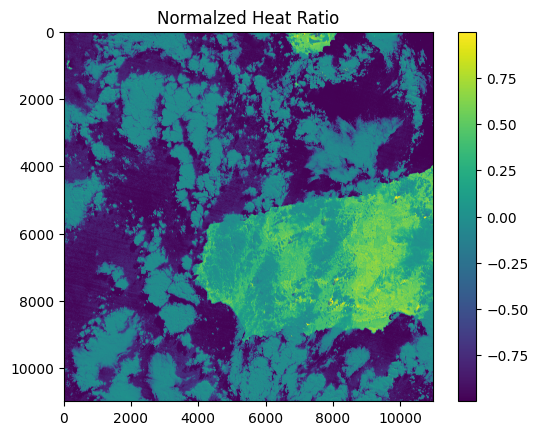

In [164]:
# Plotting the heatmap
plt.imshow(data, cmap='viridis')
plt.colorbar()
plt.title("Normalzed Heat Ratio")
plt.show()